### Introduction

This project aims to identify potential in AIM-listed shares with a market capitalization below £10 million. Specifically, it focuses on stocks that have shown significant downside and minimal upside price movement, defined as decreasing by more than 65% and increasing by less than 15% from their closing price 9 months ago. The intent is to screen for companies that may be in a full-on downtrend or have bottomed out.

Screening for significant decline is essential because it helps investors identify shares that are experiencing strong negative momentum. Such stocks often reflect underlying factors like deteriorating financial performance, unsuccessful business strategies, or decreased market interest. By identifying these declining opportunities early, investors can capitalize on the downward trends for potentially substantial returns through short selling. Furthermore, understanding these trends can also present opportunities to buy stocks at a lower price if a potential recovery is anticipated. 

As an AIM investor with enough bruises and scratches to realize that market movements are often unpredictable and vicious, making the screening of stocks for varying thresholds a necessity for you to step back and view what you want to or, more importantly, need to see to help plan your next move of attack.

We have already run the aim_casino_ticker_collect.ipynb to populate the CSV file used in this project, aim_ticker_list.csv. 

In [100]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import contextlib
import sys
import os
from tqdm import tqdm

# Function to suppress print statements
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# Load the CSV file into a DataFrame
df_loaded = pd.read_csv("aim_ticker_list.csv", index_col=0)

# Calculate the start date (9 months ago from today)
end_date = datetime.today() - timedelta(days=3)
start_date = end_date - timedelta(days=270)

# Fetch daily adjusted close price data for each symbol
data = {}
market_caps = {}

for symbol in tqdm(df_loaded.index, desc='Fetching Stock Data', unit='symbol'):
    try:
        with suppress_output():
            stock_data = yf.download(symbol, start=start_date, end=end_date)
        if not stock_data.empty:
            data[symbol] = stock_data['Adj Close']
            
            # Fetch market cap in GBP (assuming original market cap is in local currency)
            with suppress_output():
                ticker = yf.Ticker(symbol)
                market_cap = ticker.info.get('marketCap', 0)
                exchange_rate = ticker.info.get('exchangeRate', 1) if 'exchangeRate' in ticker.info else 1
                previous_close = ticker.info.get('previousClose', 1)
                latest_close = ticker.history(period='1d')['Close'].iloc[0] if not ticker.history(period='1d').empty else previous_close
                market_caps[symbol] = round((market_cap * (latest_close / previous_close) / exchange_rate) / 1e6, 2)  # Convert to millions and round to 2 decimal places
        else:
            print(f"{symbol}: No price data found, symbol may be delisted")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Convert the dictionary to a DataFrame
all_data_df = pd.DataFrame(data)

# Round all adjusted close prices to five decimal places
all_data_df = all_data_df.round(5)

# Calculate the initial prices, high and low of the adjusted close prices for the period for each stock
initial_prices = all_data_df.iloc[0]
highs = all_data_df.max()
lows = all_data_df.min()

# Calculate max % increase and max % decrease from the initial prices
max_increase_percent = round(((highs - initial_prices) / initial_prices) * 100, 2)
max_decrease_percent = round(((lows - initial_prices) / initial_prices) * 100, 2)

# Transpose the DataFrame to have stock symbols as rows
all_data_df_transposed = all_data_df.T

# Add the market cap, initial prices, highs, lows, max increase and max decrease data
all_data_df_transposed['Market Cap (GBP millions)'] = pd.Series(market_caps)
all_data_df_transposed['Initial Price'] = initial_prices
all_data_df_transposed['High Price'] = highs
all_data_df_transposed['Low Price'] = lows
all_data_df_transposed['Max Increase (%)'] = max_increase_percent
all_data_df_transposed['Max Decrease (%)'] = max_decrease_percent

# Save the DataFrame with the new columns to a CSV file
aim_df = all_data_df_transposed.copy()
aim_df.to_csv("aim_analysis.csv")

# Display the first few rows of the DataFrame with the new columns
aim_df.head()

# When fetching stock data for the tickers, be prepared to encounter a few issues.
# This is common due to the nature of the market, where some shares may become
# suspended or delisted regularly. These issues can be investigated further
# to understand their causes and implications.


Fetching Stock Data:  75%|█████████████████████████████████████████▏             | 545/728 [02:16<00:43,  4.21symbol/s]

Error fetching data for RGO.L: float division by zero


Fetching Stock Data: 100%|███████████████████████████████████████████████████████| 728/728 [03:05<00:00,  3.91symbol/s]


Date,2023-10-24 00:00:00,2023-10-25 00:00:00,2023-10-26 00:00:00,2023-10-27 00:00:00,2023-10-30 00:00:00,2023-10-31 00:00:00,2023-11-01 00:00:00,2023-11-02 00:00:00,2023-11-03 00:00:00,2023-11-06 00:00:00,...,2024-07-16 00:00:00,2024-07-17 00:00:00,2024-07-18 00:00:00,2024-07-19 00:00:00,Market Cap (GBP millions),Initial Price,High Price,Low Price,Max Increase (%),Max Decrease (%)
SPA.L,48.000,48.00,48.000,47.50,47.50,47.50,47.500,48.00,48.00,48.000,...,69.000,69.00,71.000,71.000,77.23,48.000,76.00,46.000,58.33,-4.17
450.L,1.800,1.80,1.800,1.80,1.80,1.80,1.800,1.80,1.80,1.800,...,2.100,2.10,2.100,2.100,14.09,1.800,2.10,0.018,16.67,-99.00
4BB.L,550.000,550.00,500.000,510.00,505.00,515.00,515.000,515.00,515.00,510.000,...,1515.000,1500.00,1500.000,1475.000,188.96,550.000,1820.00,500.000,230.91,-9.09
4GBL.L,62.500,62.50,62.500,62.50,62.50,62.00,62.000,62.00,62.00,58.500,...,46.500,46.50,46.000,46.000,12.38,62.500,62.50,43.500,0.00,-30.40
88E.L,0.325,0.35,0.325,0.35,0.35,0.35,0.325,0.35,0.35,0.325,...,0.108,0.11,0.113,0.113,30.40,0.325,0.38,0.098,16.92,-69.85


All necessary data has been collected. Now, let's load it and filter according to our chosen specifications to identify potential investment opportunities. Collecting all data first and then applying filters ensures a comprehensive analysis and reduces the likelihood of missing critical data points. This approach also allows for more efficient processing.

In [5]:
import pandas as pd

# Load the CSV file into a DataFrame
aim_df = pd.read_csv('aim_analysis.csv')

# Ensure that 'Max % Decrease' and other relevant columns are numeric
aim_df['Max Decrease (%)'] = pd.to_numeric(aim_df['Max Decrease (%)'], errors='coerce')
aim_df['Market Cap (GBP millions)'] = pd.to_numeric(aim_df['Market Cap (GBP millions)'], errors='coerce')
aim_df['Max Increase (%)'] = pd.to_numeric(aim_df['Max Increase (%)'], errors='coerce')
aim_df['Initial Price'] = pd.to_numeric(aim_df['Initial Price'], errors='coerce')

# Define the threshold percentages
max_increase_percent = 15
max_decrease_percent = -75

# Filter the DataFrame based on the given criteria
aim_filtered = aim_df[
    (aim_df['Market Cap (GBP millions)'] < 10) &  # Market cap less than £10 million
    (aim_df['Max Increase (%)'] < max_increase_percent) &  # Max increase in price
    (aim_df['Max Decrease (%)'] < max_decrease_percent)  # Max decrease in price
].copy()


# Display the filtered DataFrame
aim_filtered



,Unnamed: 0,2023-10-25 00:00:00,2023-10-26 00:00:00,2023-10-27 00:00:00,2023-10-30 00:00:00,2023-10-31 00:00:00,2023-11-01 00:00:00,2023-11-02 00:00:00,2023-11-03 00:00:00,2023-11-06 00:00:00,...,2024-07-16 00:00:00,2024-07-17 00:00:00,2024-07-18 00:00:00,2024-07-19 00:00:00,Market Cap (GBP millions),Initial Price,High Price,Low Price,Max Increase (%),Max Decrease (%)
9,AEG.L,4.3500,4.3500,4.3500,4.3500,4.3500,4.3500,4.1250,4.1250,4.1250,...,0.00055,0.00055,0.00055,0.00055,0.09,4.3500,4.3500,0.00055,0.00,-99.99
13,ADME.L,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,0.5000,...,0.00425,0.00425,0.00425,0.00425,2.67,0.5000,0.5500,0.00425,10.00,-99.15
87,BVX.L,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,...,13.00000,13.00000,13.00000,13.00000,9.29,13.0000,13.0000,0.11500,0.00,-99.12
96,BLVN.L,0.6500,0.6500,0.6500,0.7150,0.6500,0.6500,0.6500,0.6500,0.6500,...,0.25000,0.22500,0.22500,0.22500,3.01,0.6500,0.7150,0.11710,10.00,-81.98
144,CLCO.L,0.9500,0.9500,0.9500,0.9500,0.9500,0.9500,0.9500,0.9500,0.9500,...,0.22500,0.22500,0.22500,0.17500,2.32,0.9500,0.9500,0.00750,0.00,-99.21
161,CORO.L,0.2600,0.2600,0.2600,0.2550,0.2530,0.2530,0.2550,0.2500,0.2450,...,0.00138,0.00138,0.00138,0.00138,3.94,0.2600,0.2850,0.00138,9.62,-99.47
186,DBOX.L,3.7500,3.7500,3.7500,3.7500,3.7500,3.7500,3.7500,3.7500,3.7500,...,3.80000,3.80000,3.80000,3.80000,4.48,3.7500,4.2500,0.03750,13.33,-99.00
187,DSG.L,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,13.0000,...,9.00000,9.00000,9.00000,9.00000,0.00,13.0000,13.0000,0.11000,0.00,-99.15
196,EARN.L,42.5000,42.5000,42.5000,42.5000,42.5000,41.5000,41.5000,43.9000,41.5000,...,7.75000,7.75000,7.75000,7.75000,5.06,42.5000,43.9000,7.25000,3.29,-82.94
275,GFIN.L,0.0750,0.0750,0.0750,0.0750,0.0700,0.0750,0.0850,0.0770,0.0780,...,0.02600,0.02200,0.02400,0.02400,0.94,0.0750,0.0850,0.01700,13.33,-77.33


In [6]:
# If you want to save the filtered results to a new CSV file
aim_filtered.to_csv("aim_casino_screener_significant_decline.csv", index=False)

### Plots

In our analysis, we use the initial price as the baseline and establish thresholds based on our specified criteria. These thresholds represent the range within which we require the stock price to either remain or exceed, depending on our preference. The specific high and low annotations on our chart illustrate how closely the stock prices have adhered to these thresholds. This visualization lets us see the behavior of the screened stocks' prices.

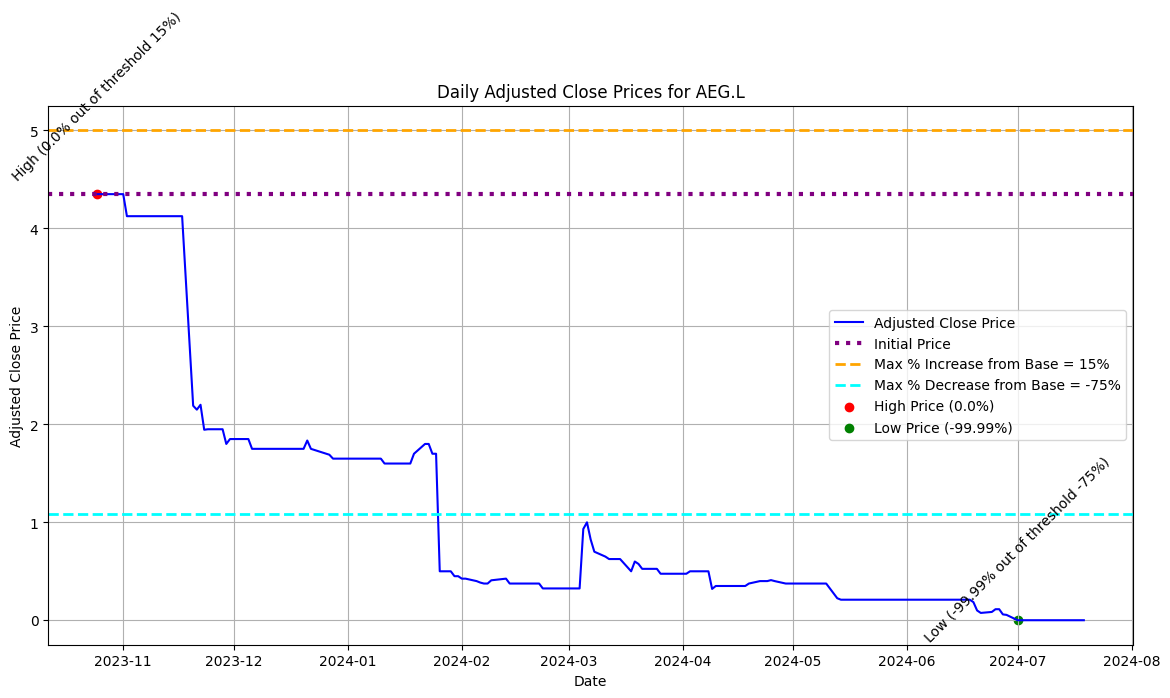

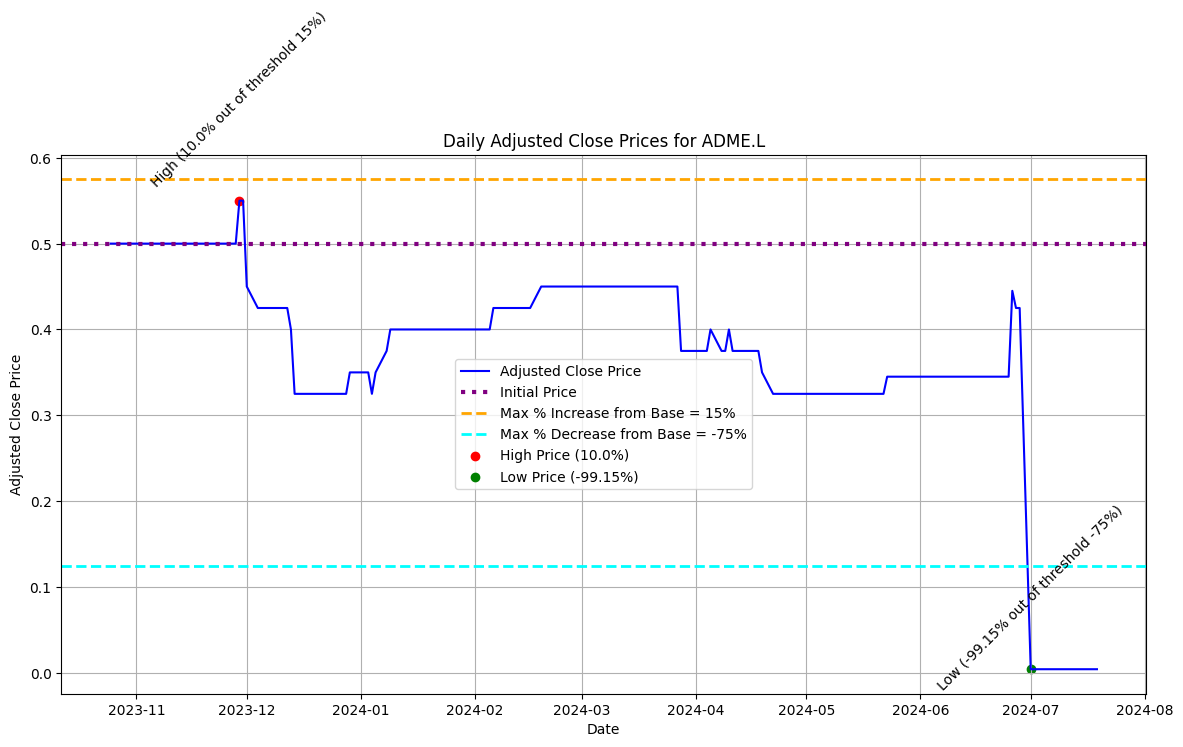

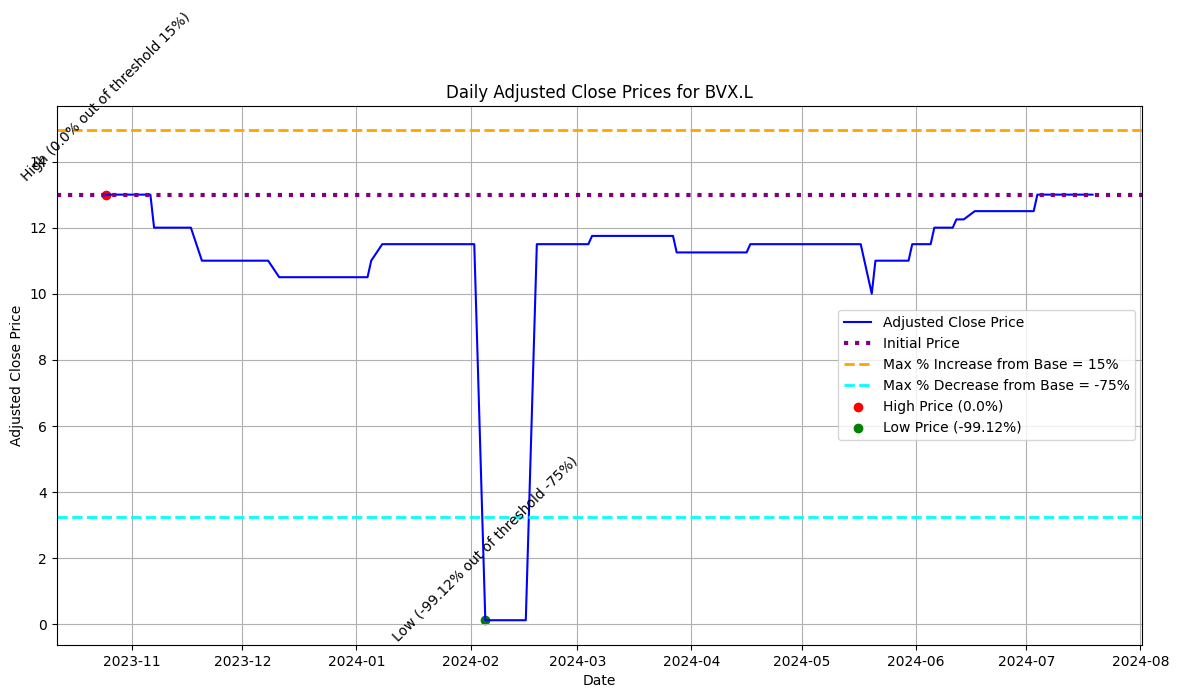

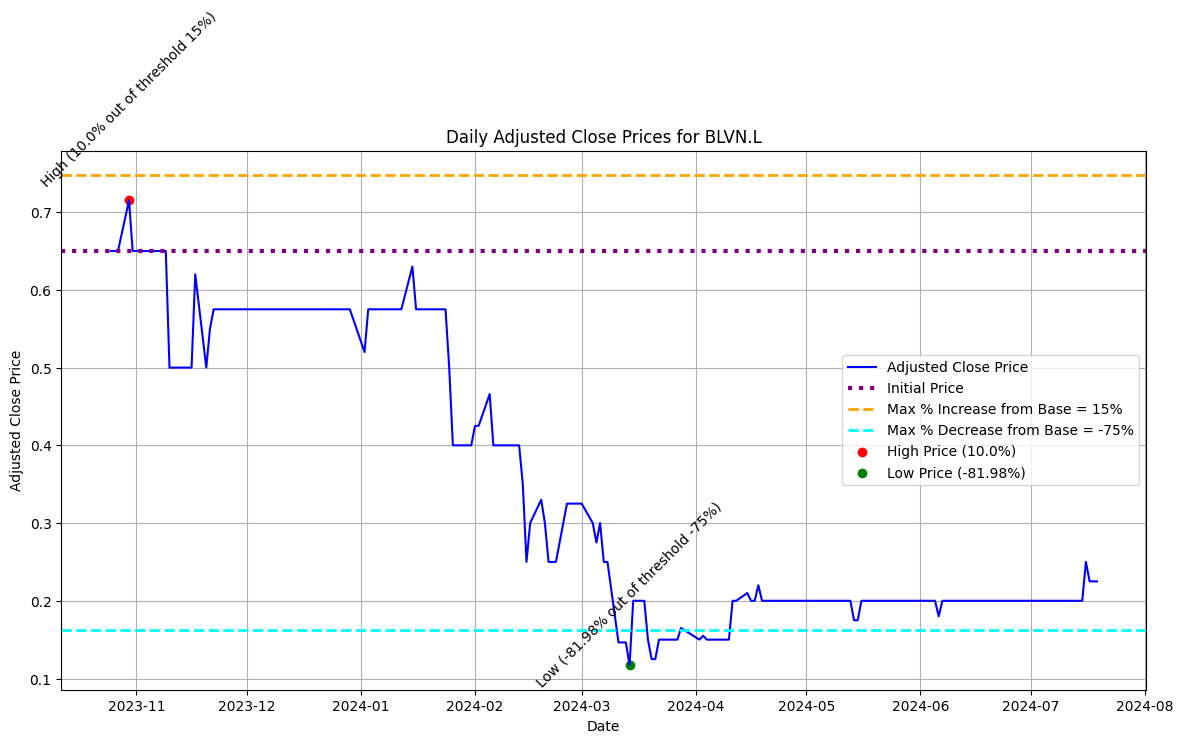

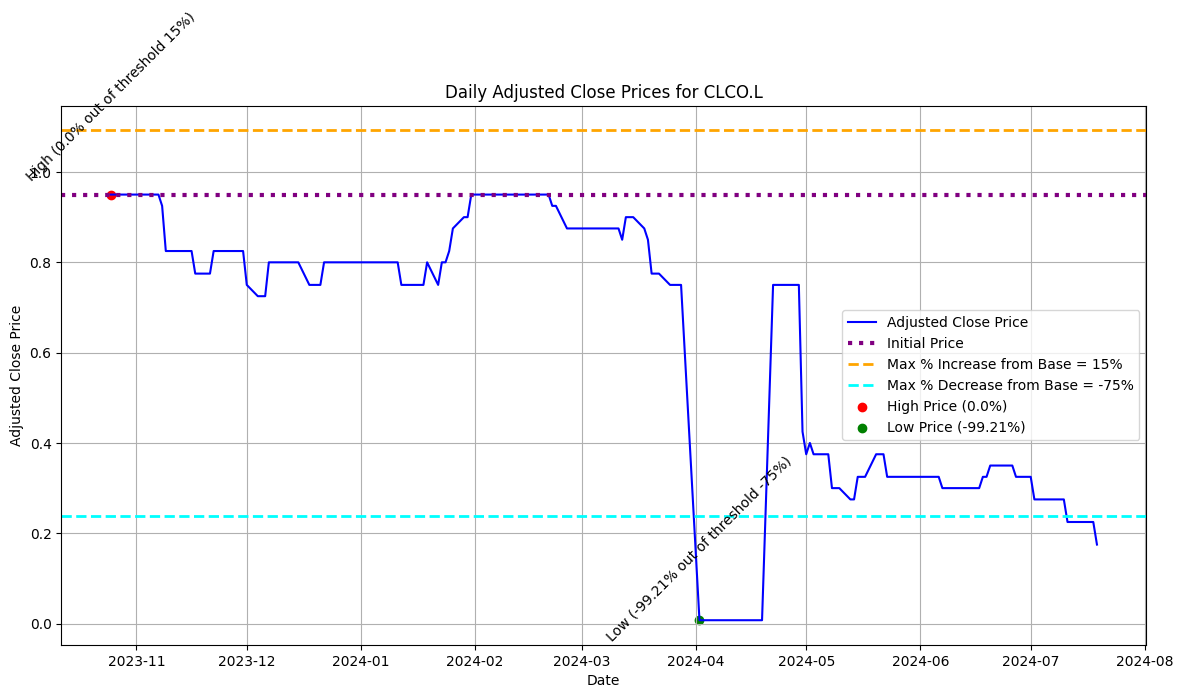

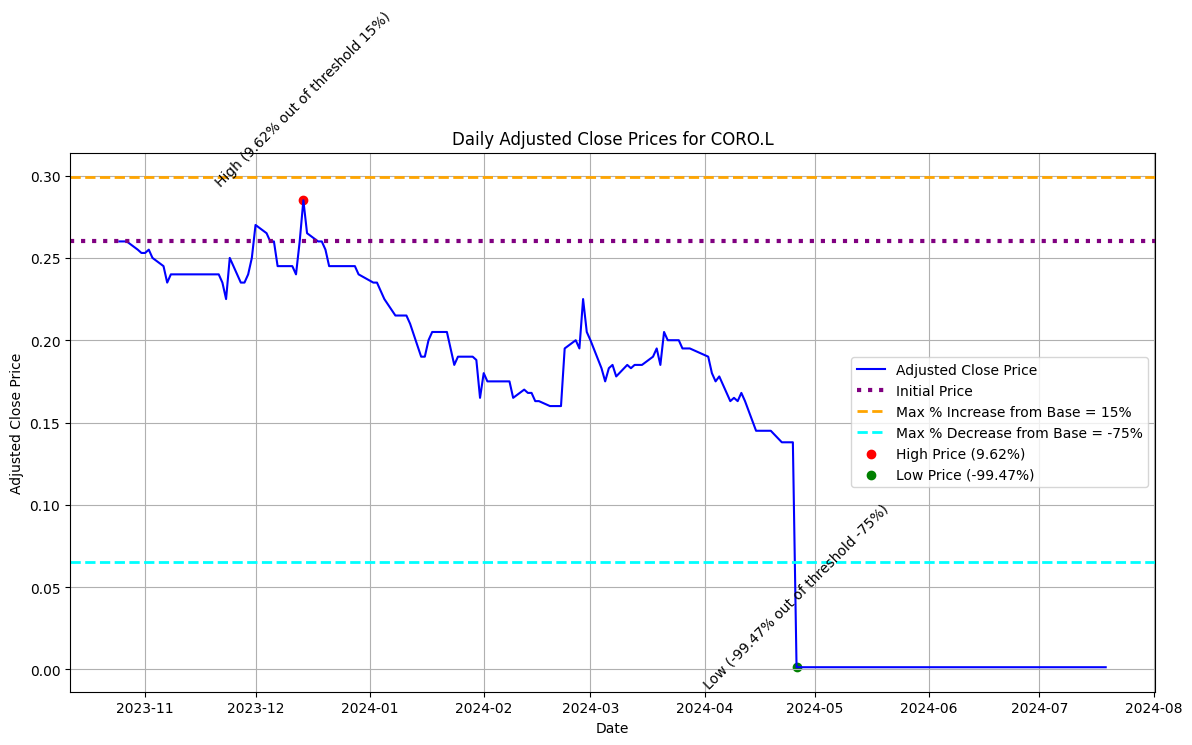

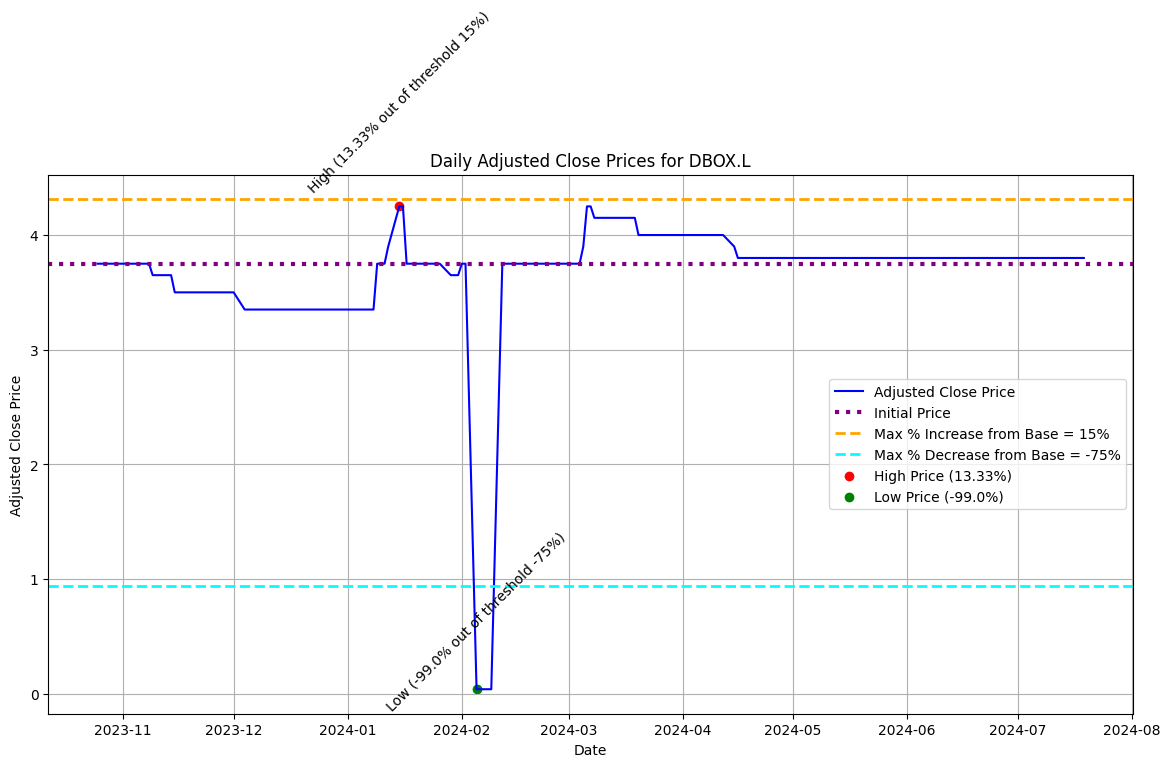

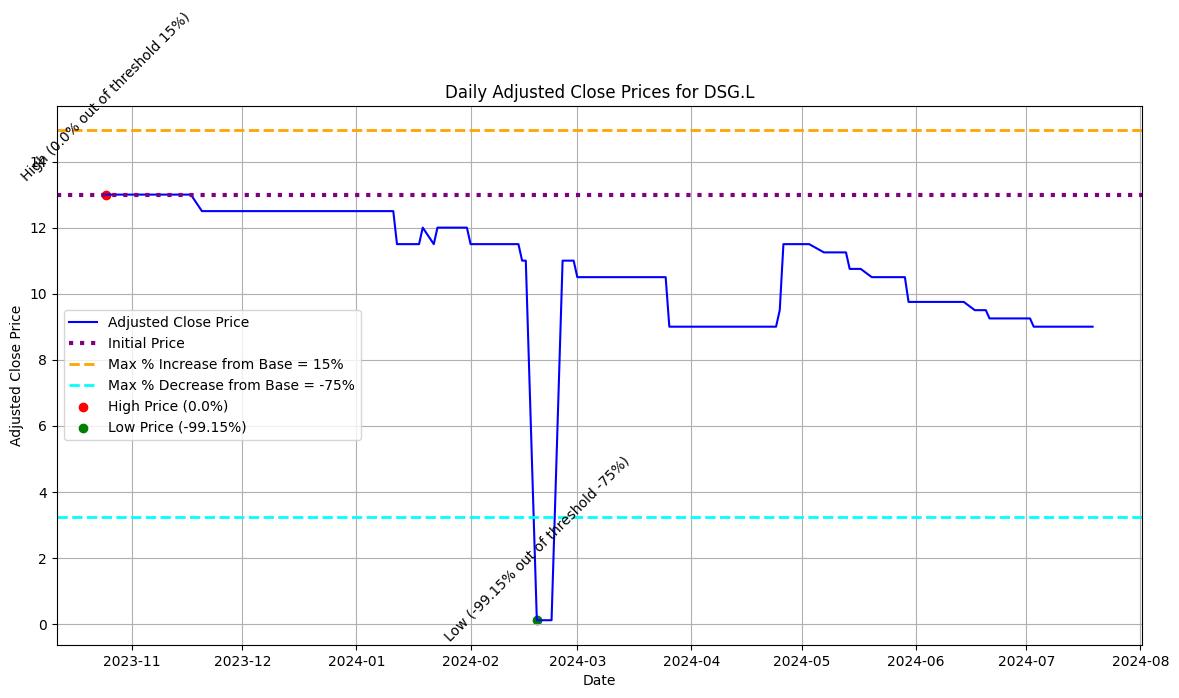

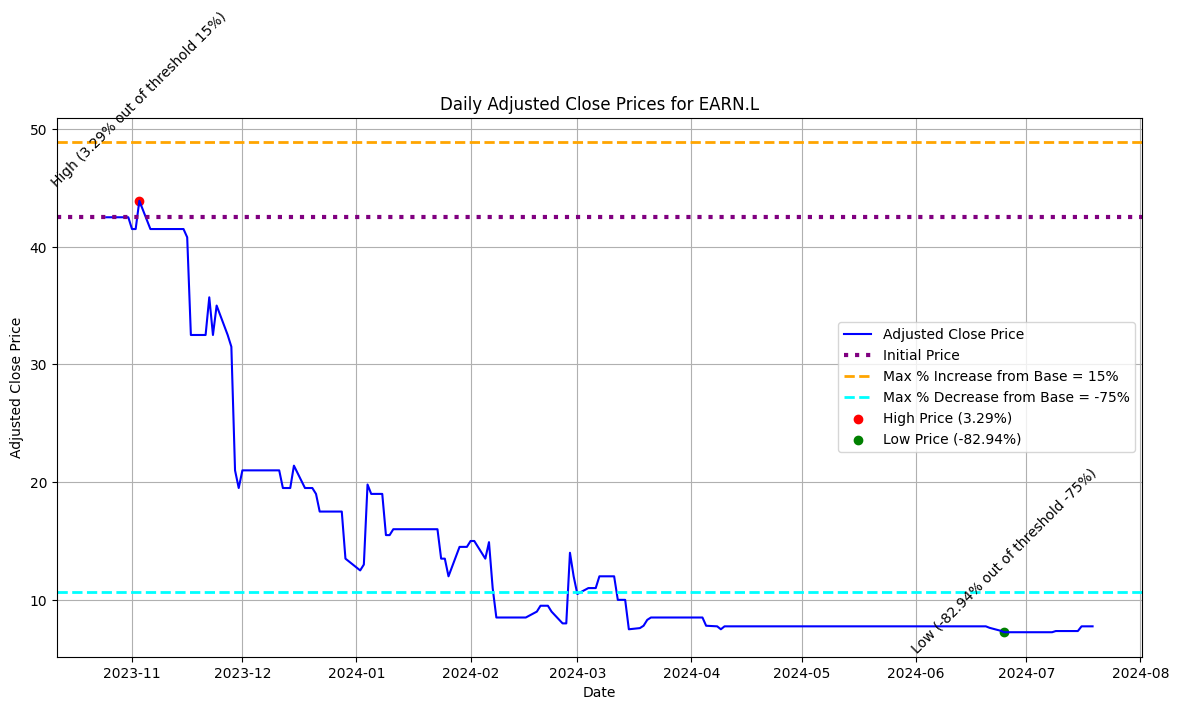

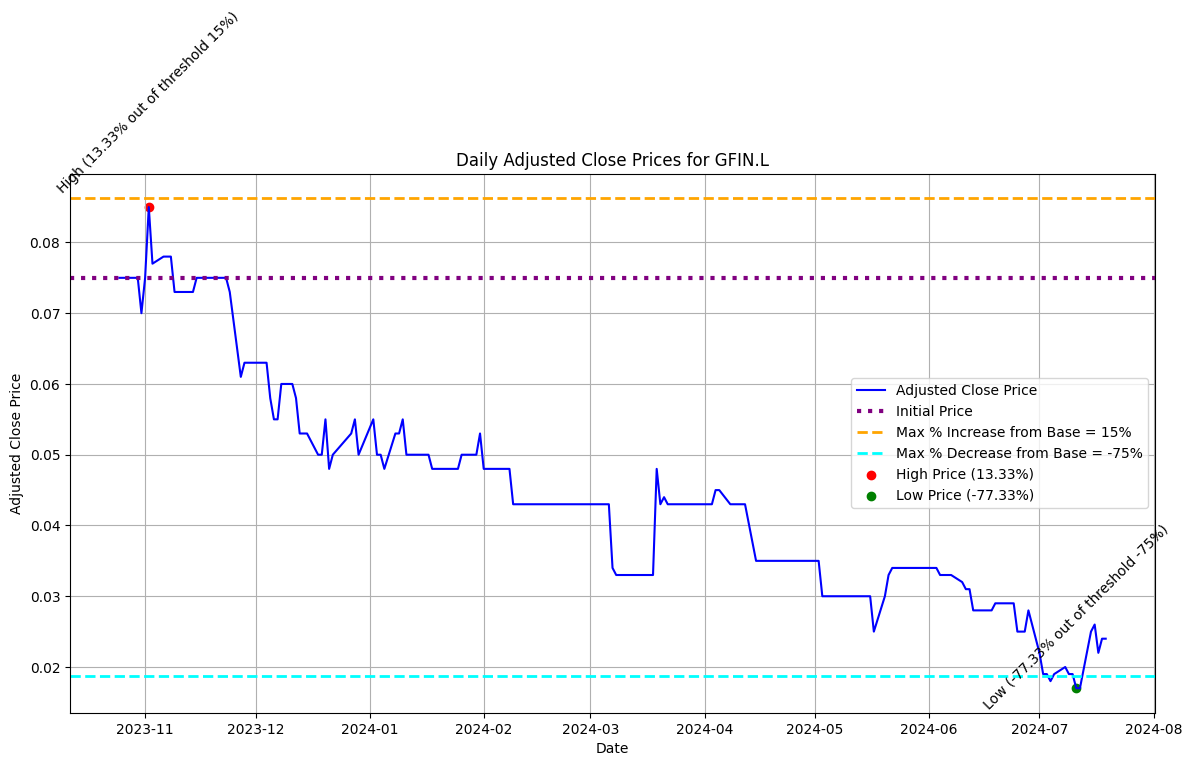

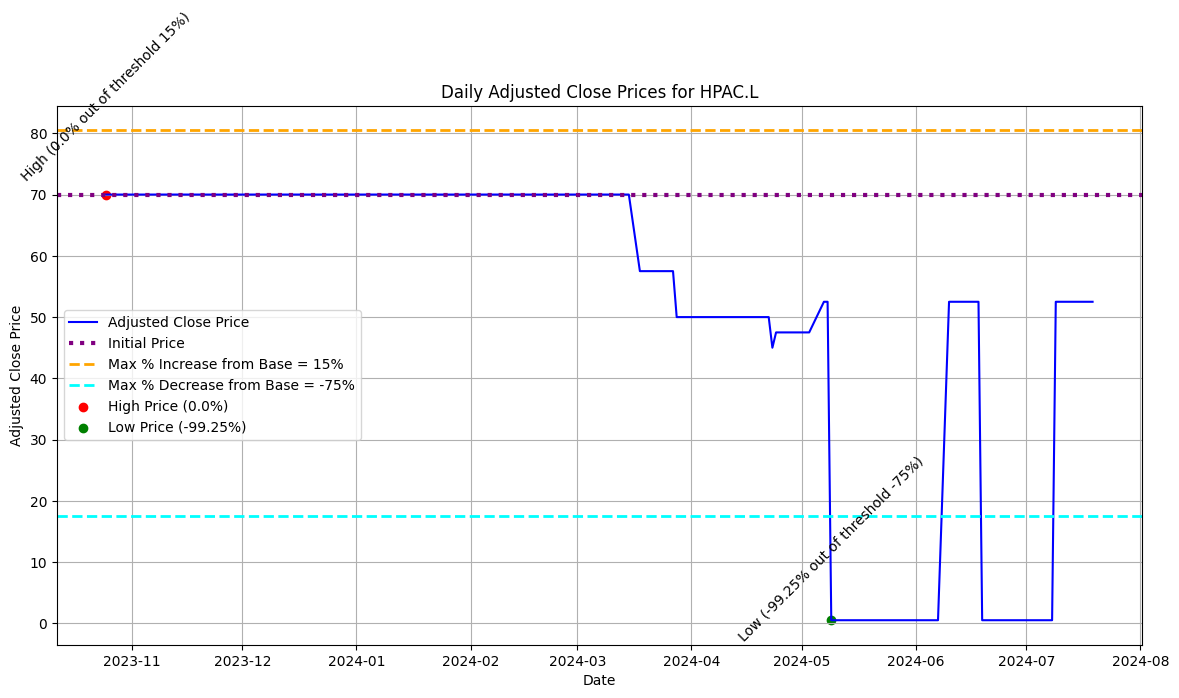

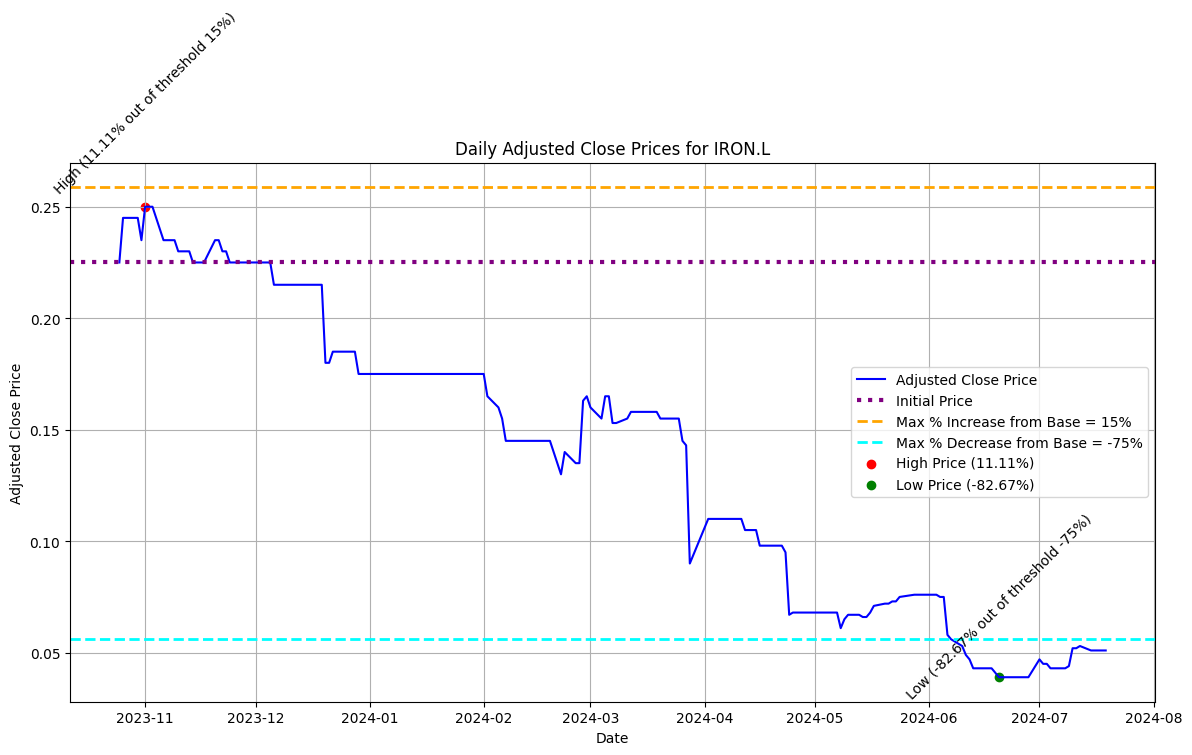

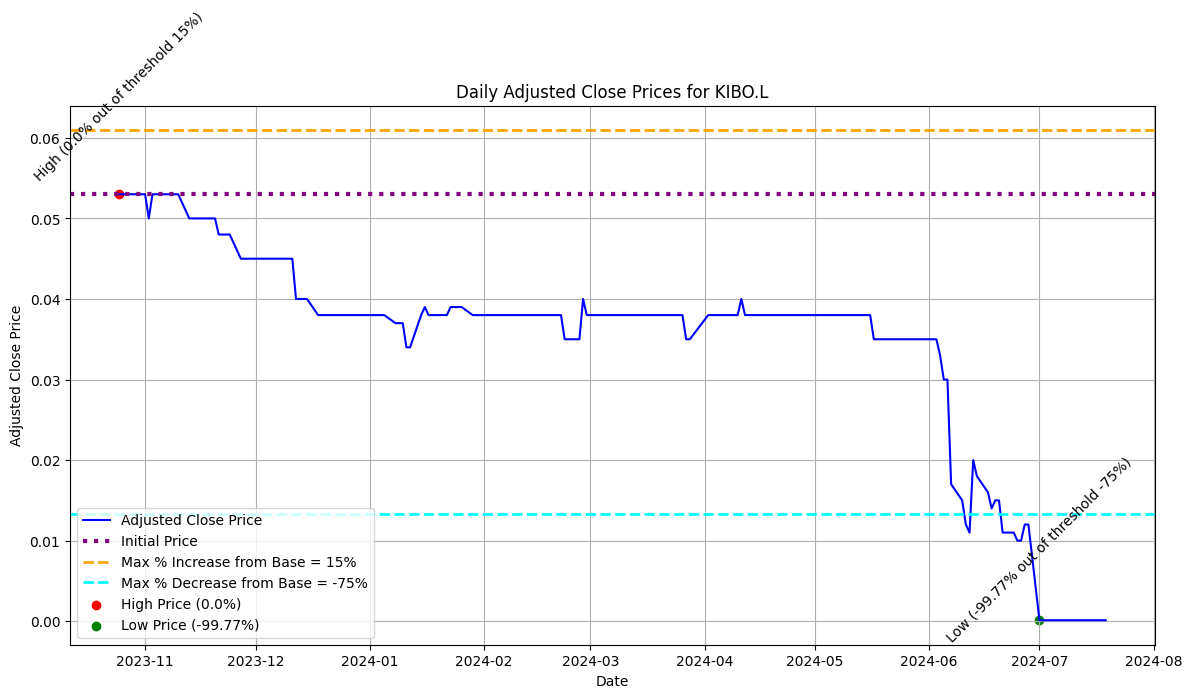

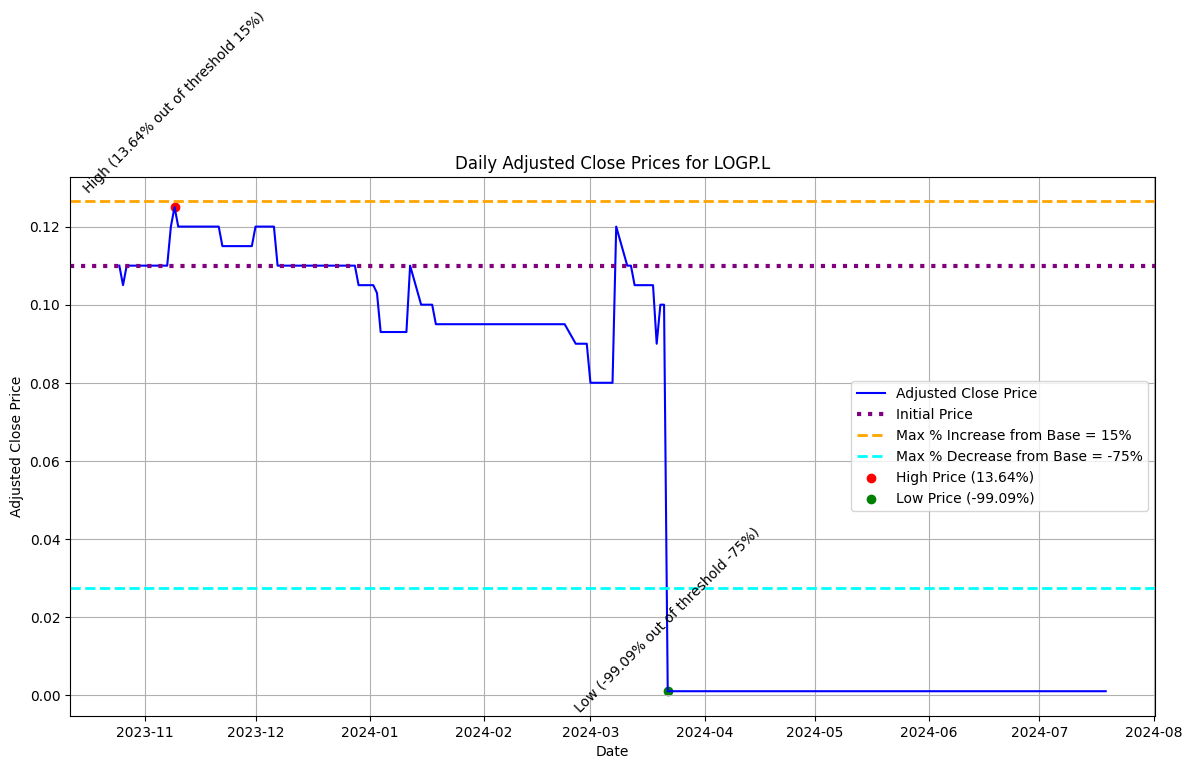

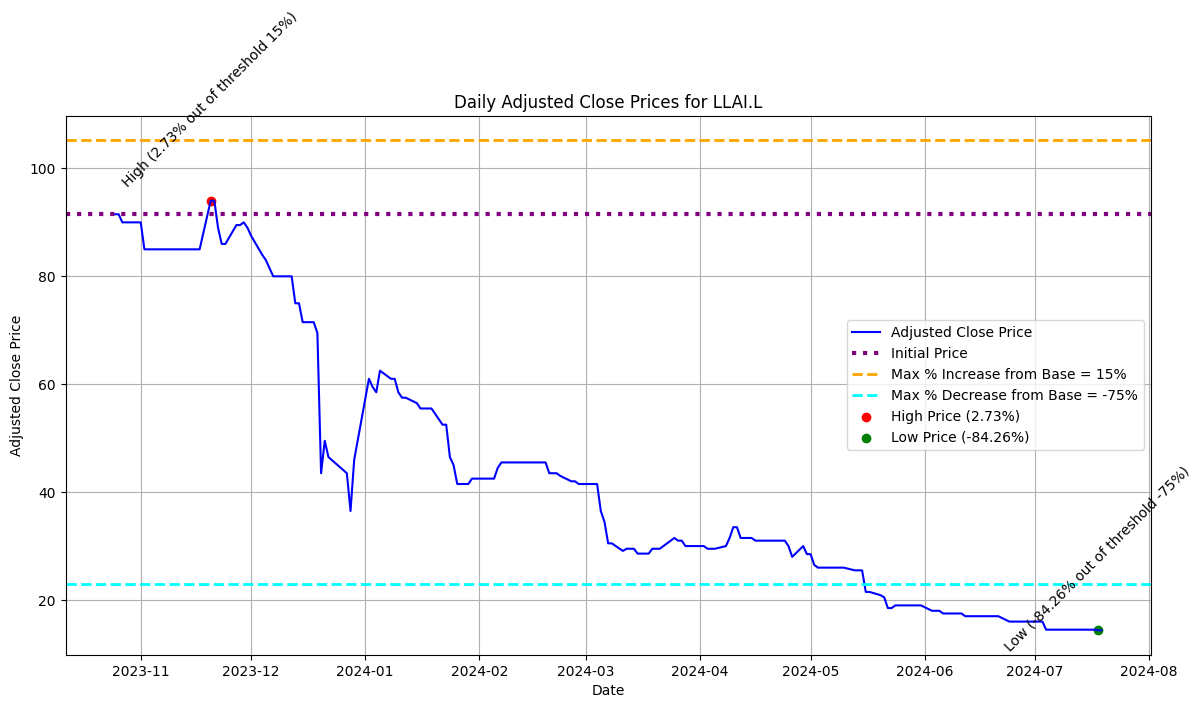

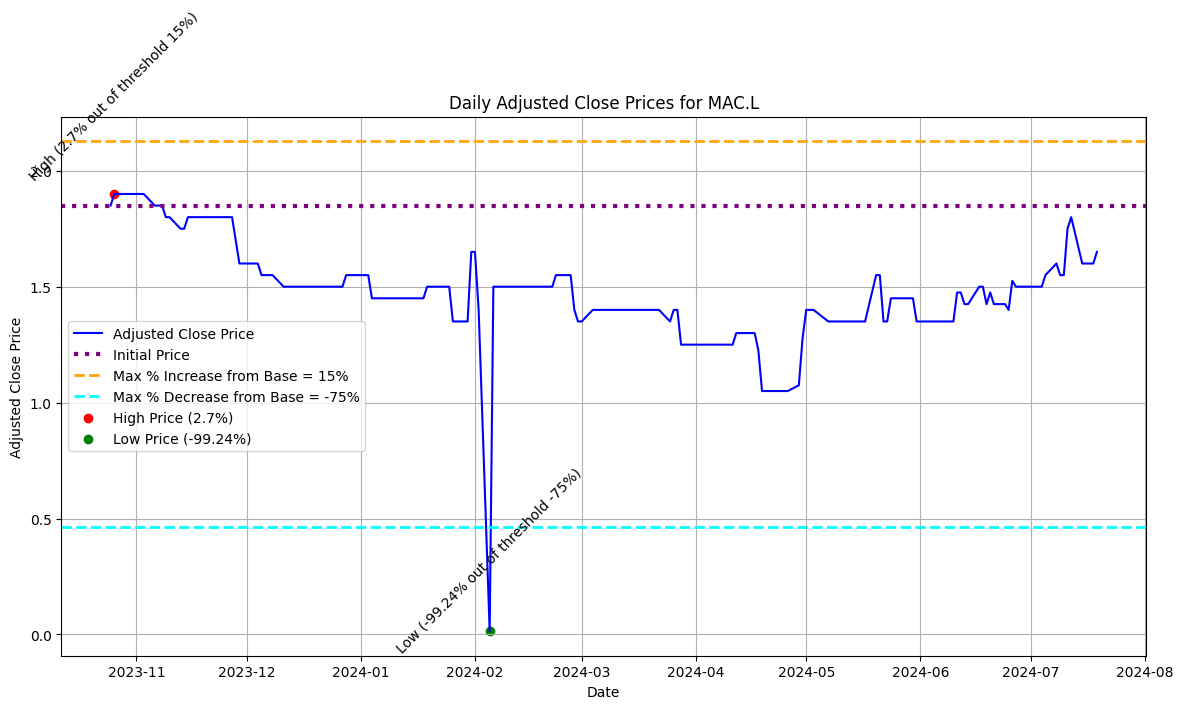

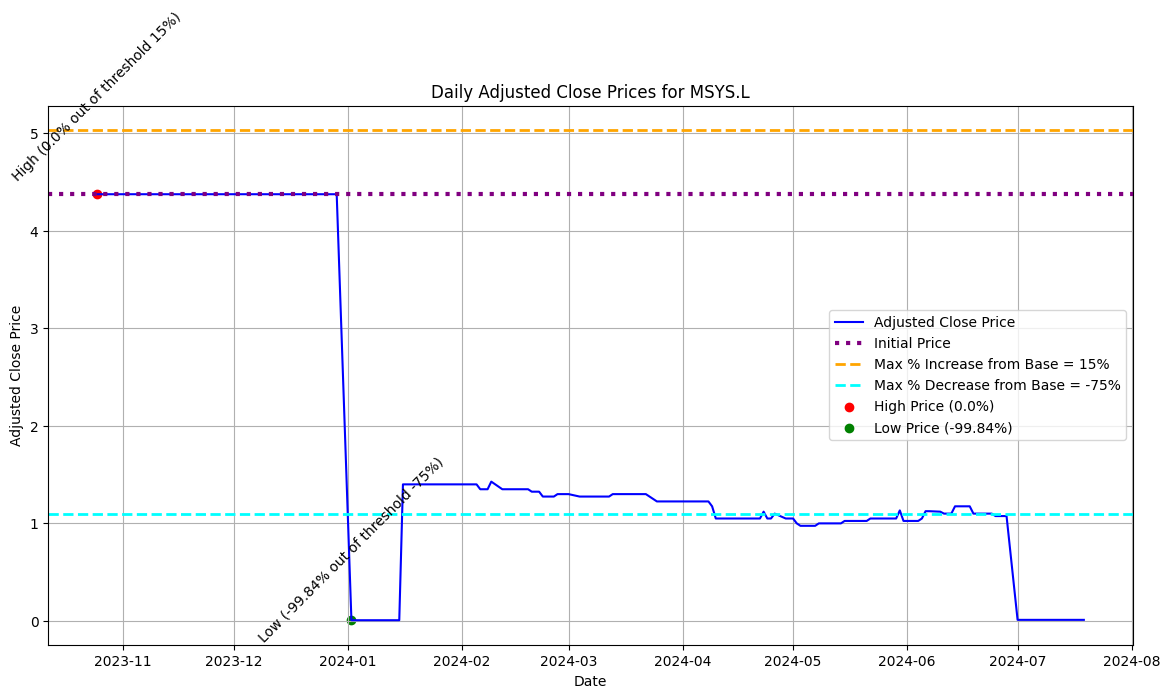

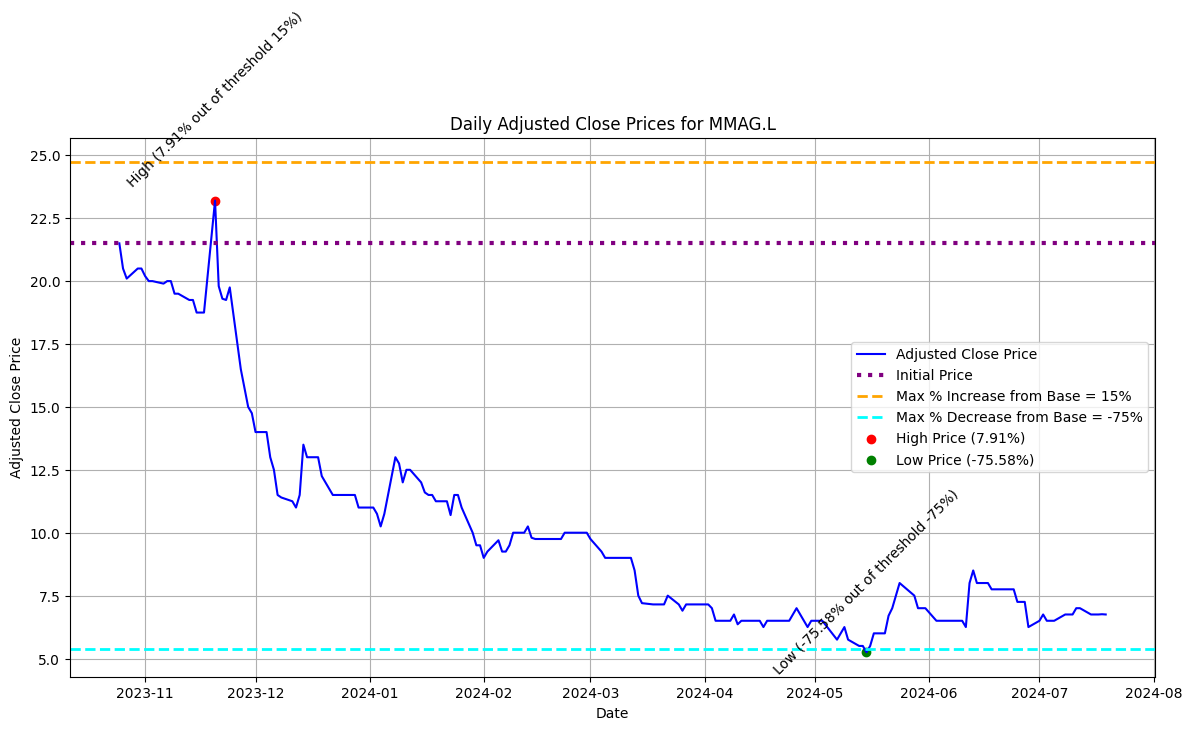

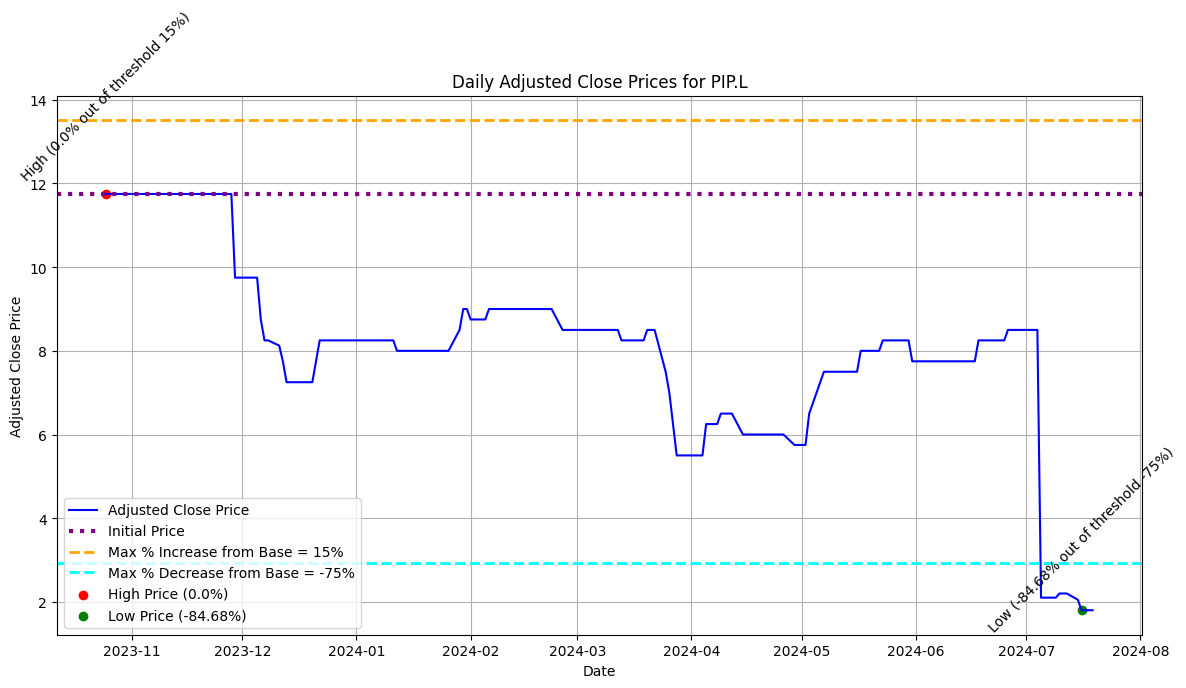

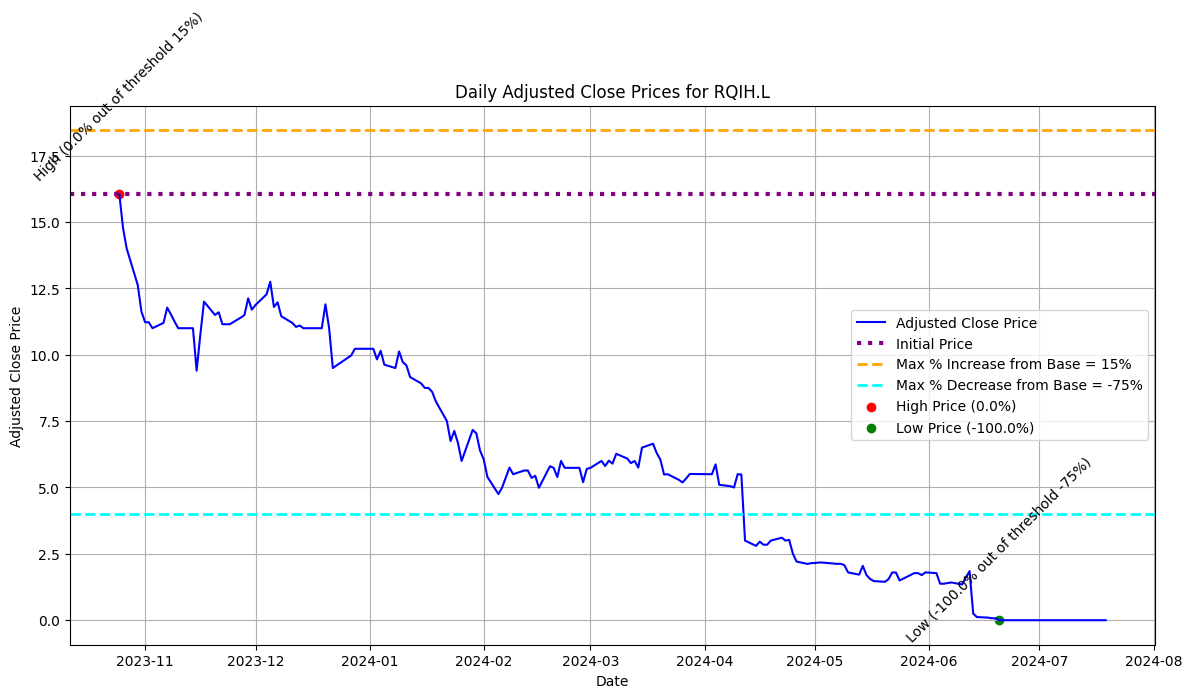

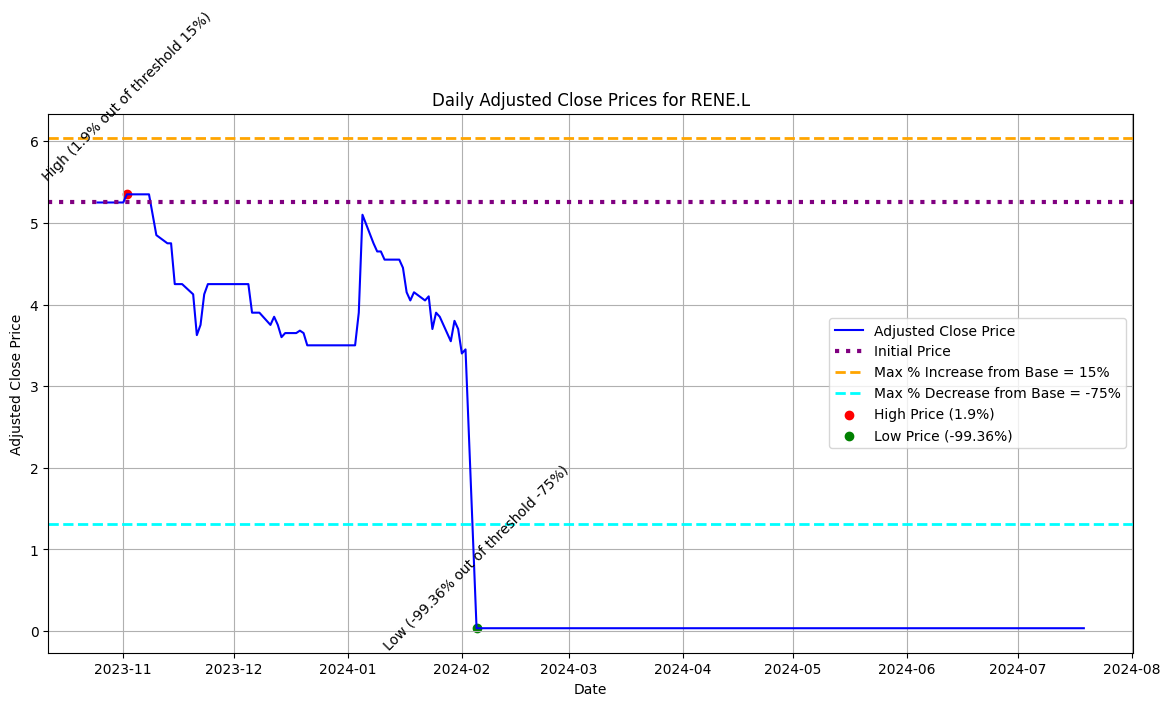

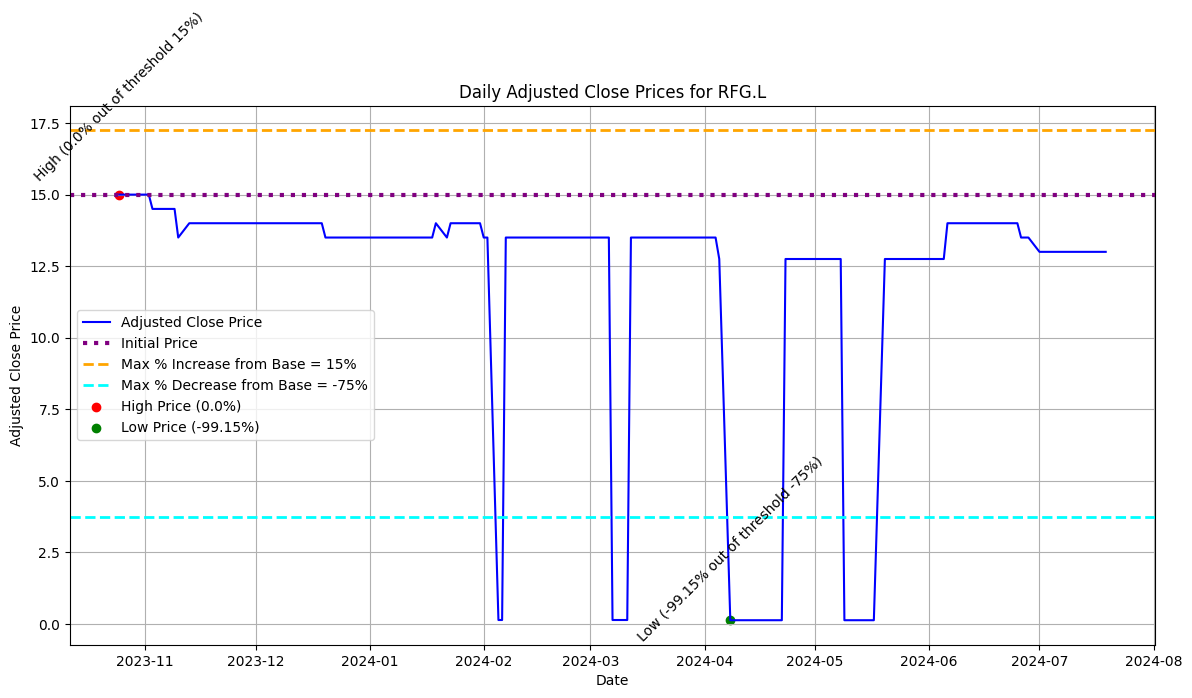

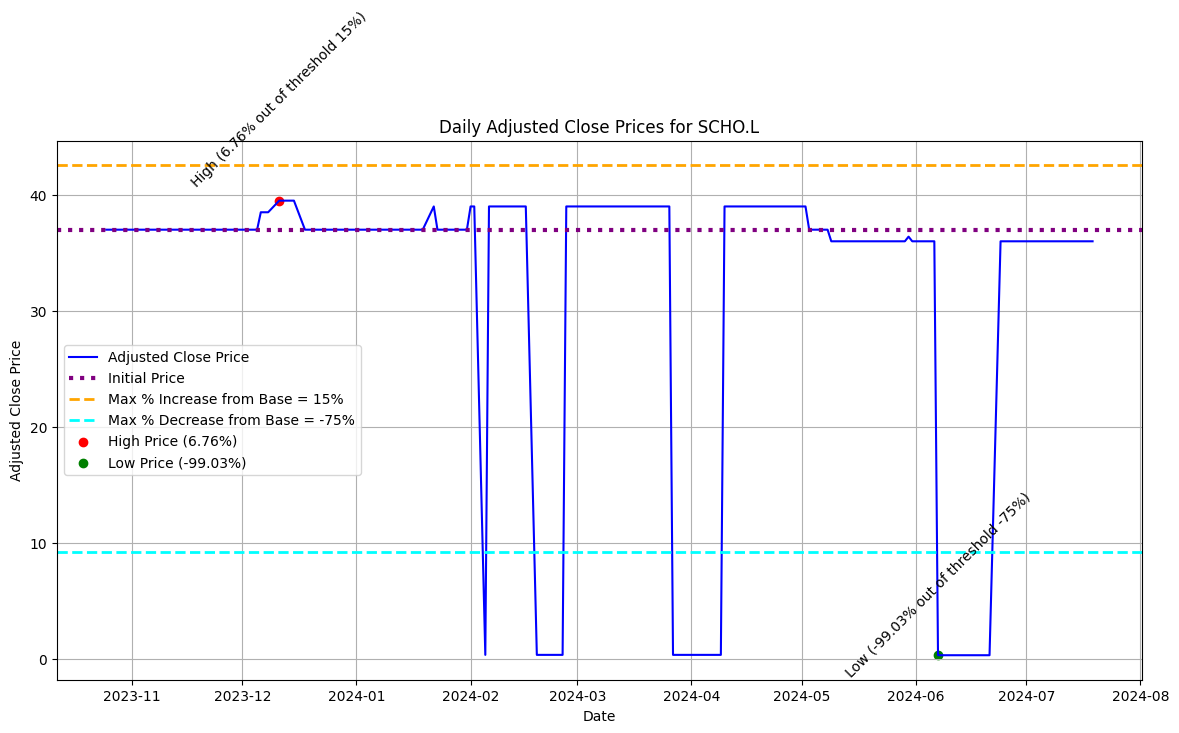

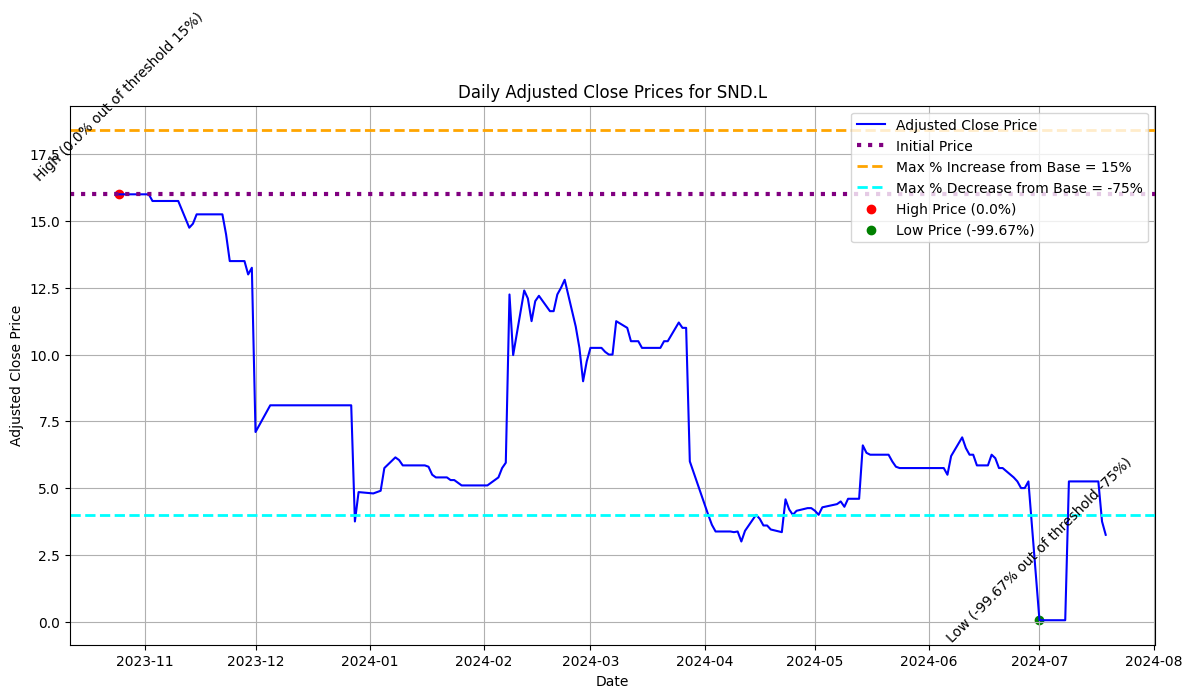

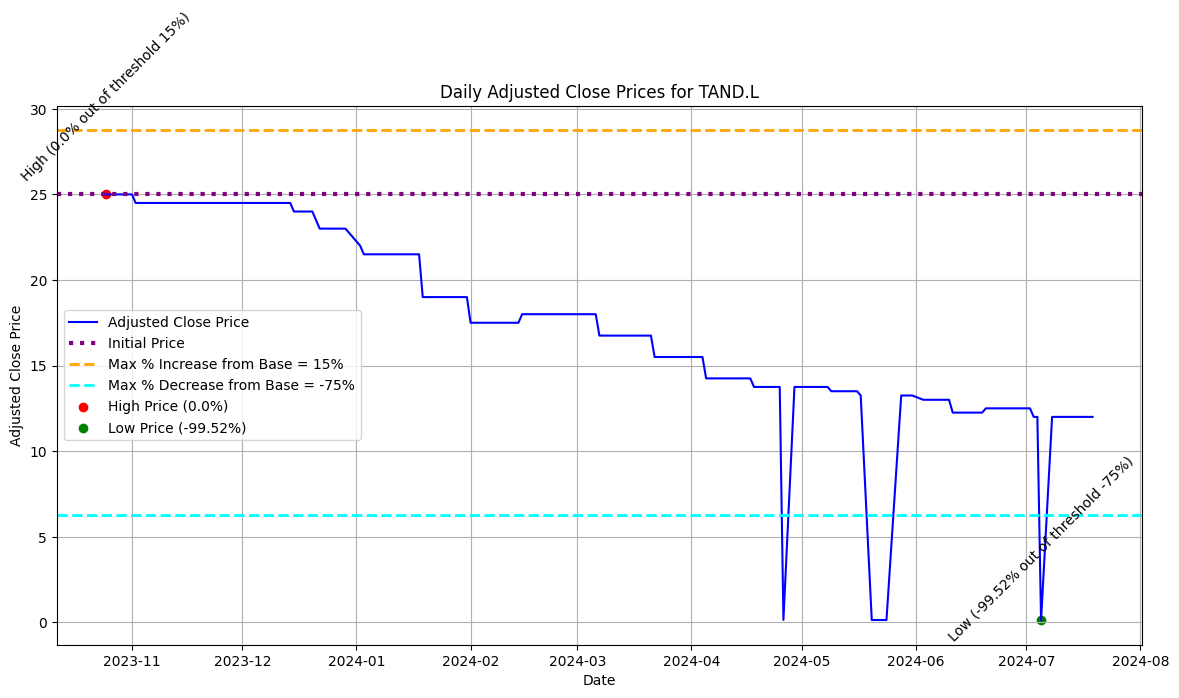

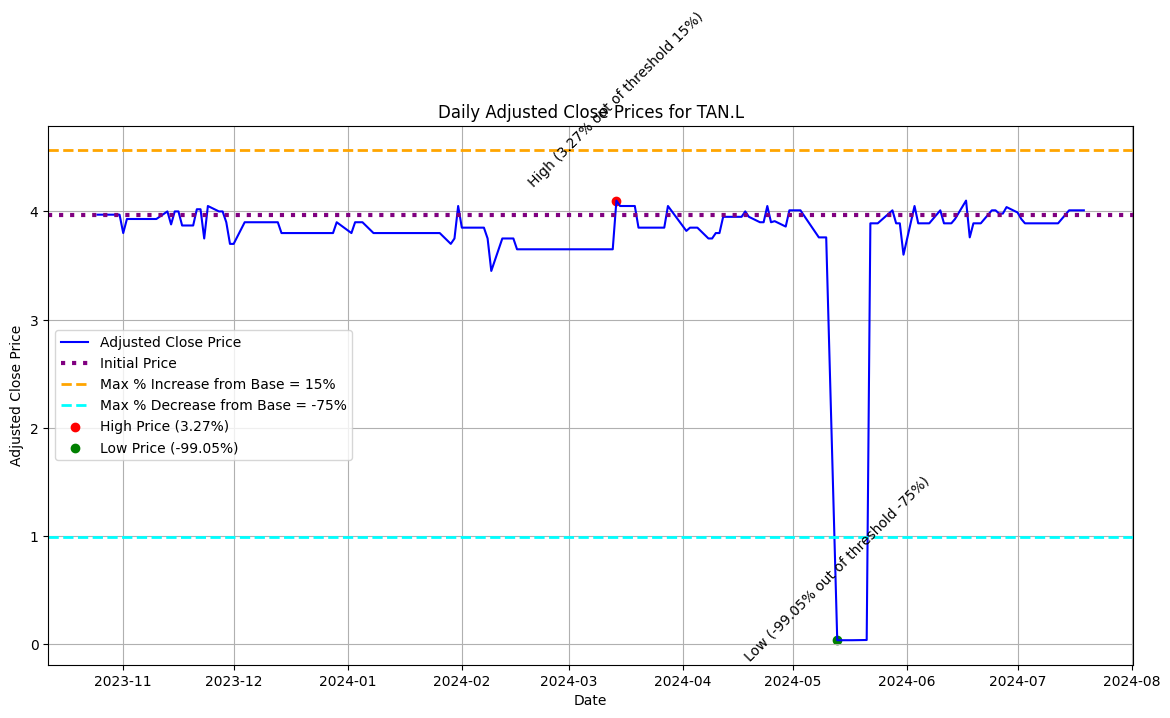

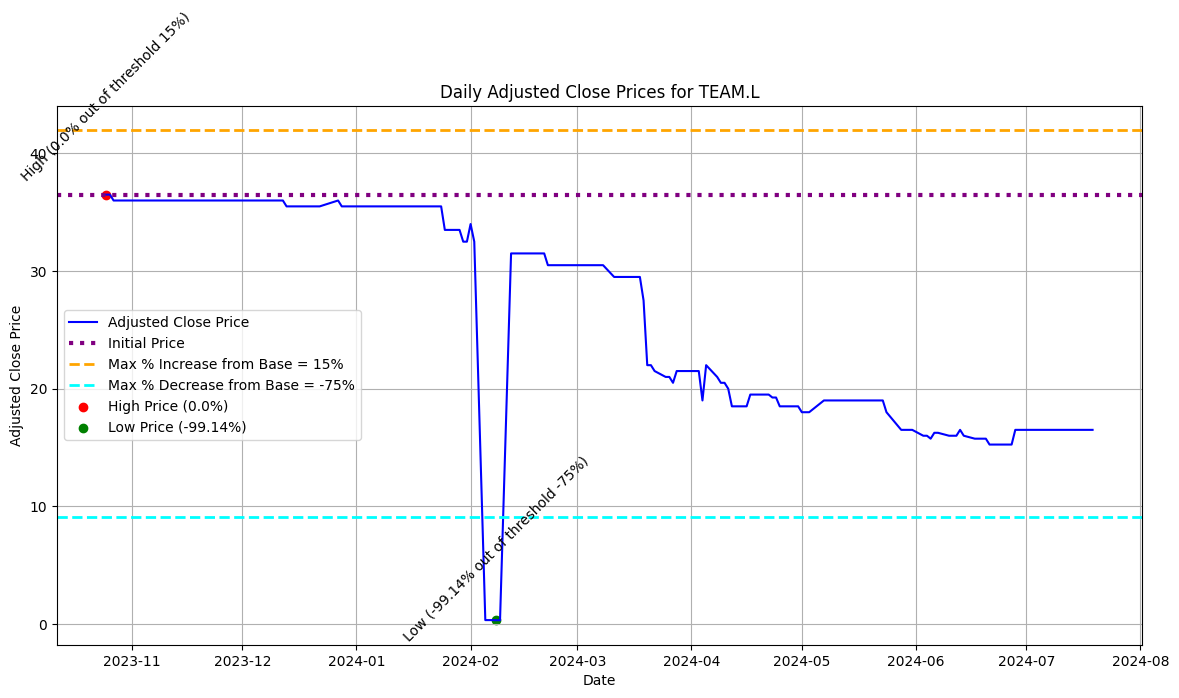

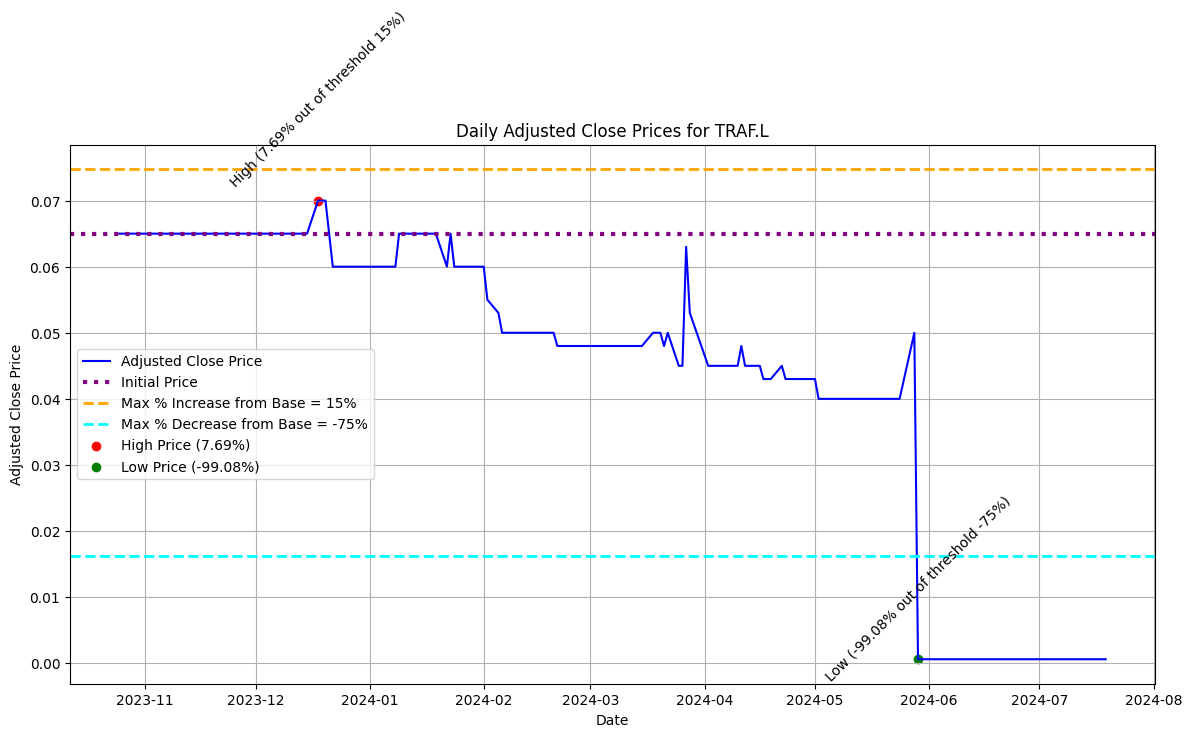

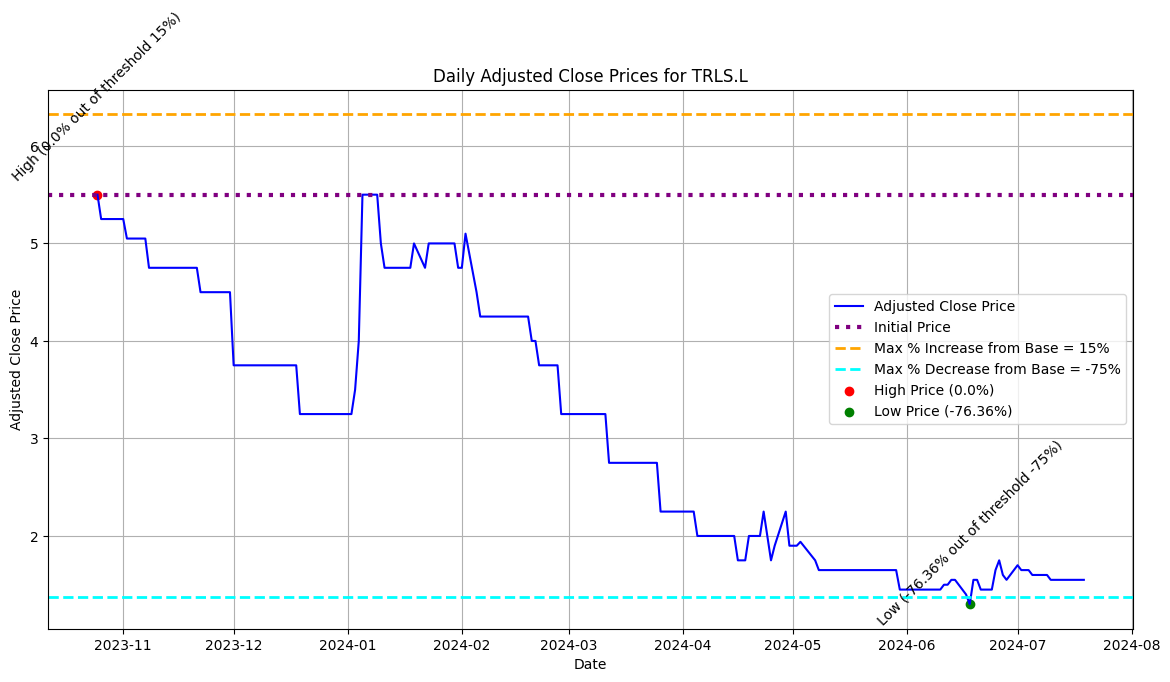

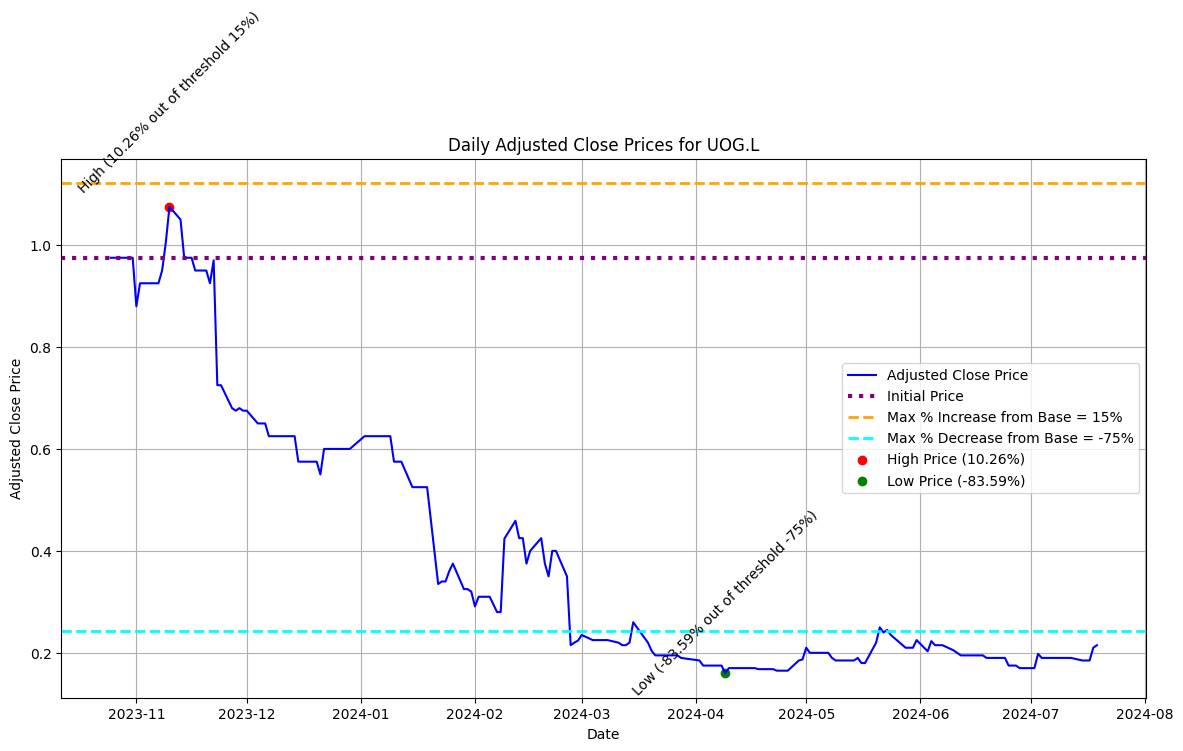

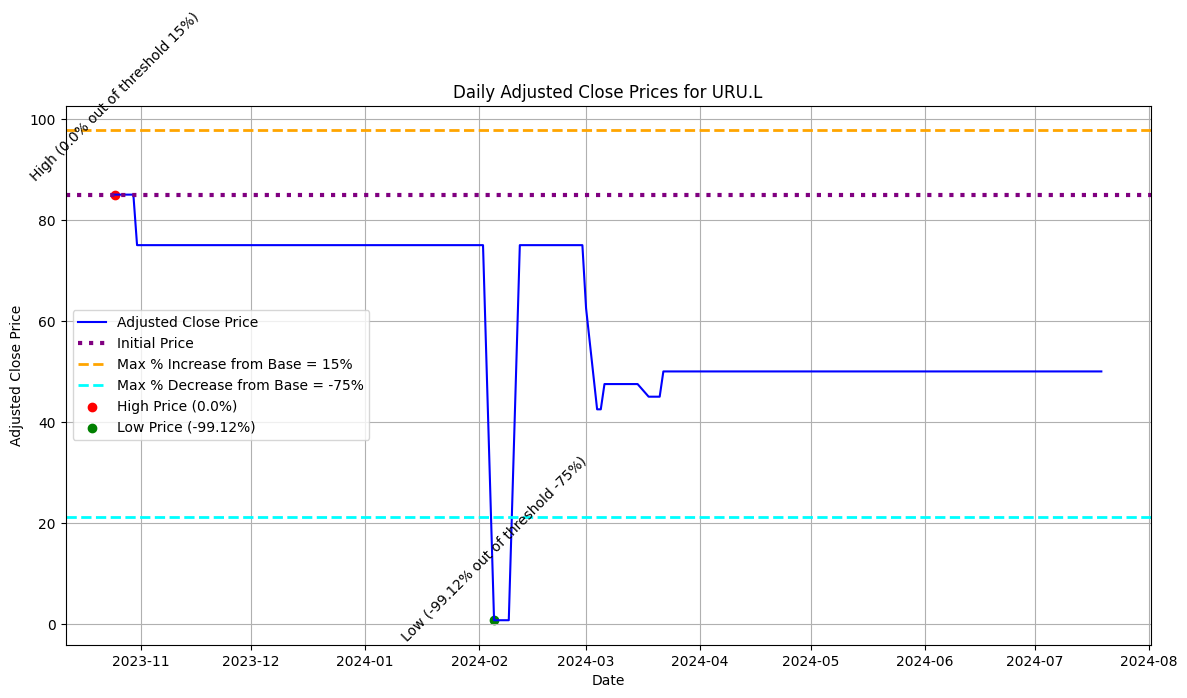

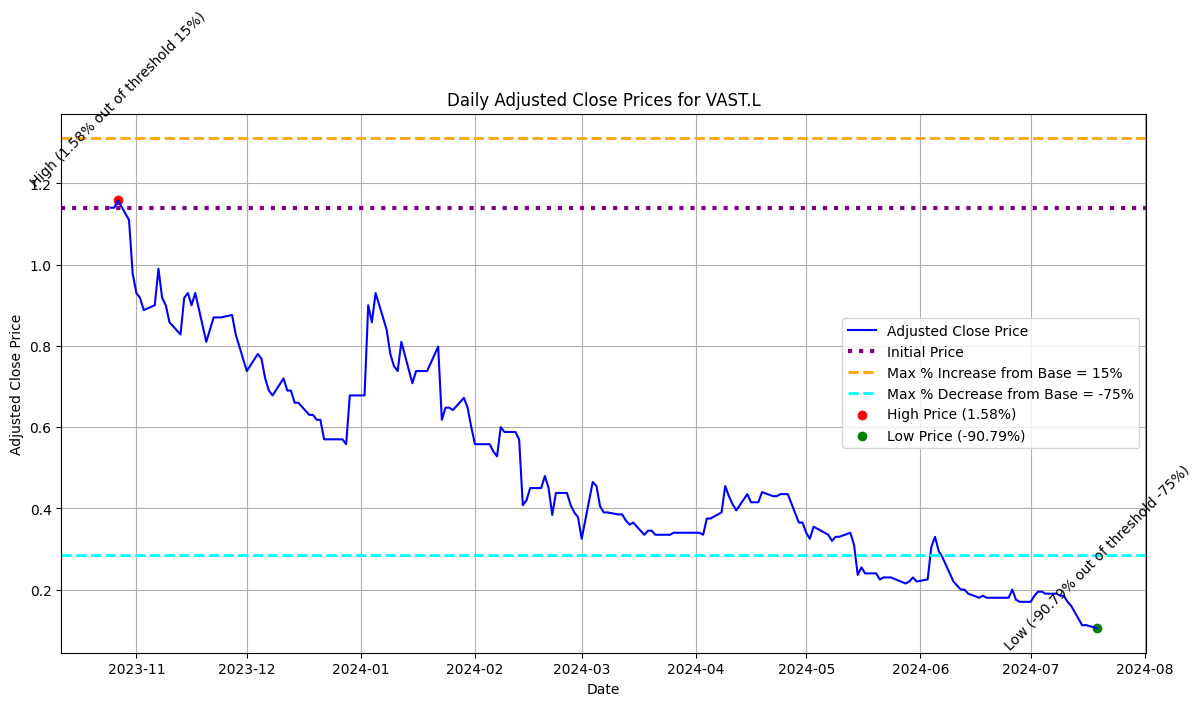

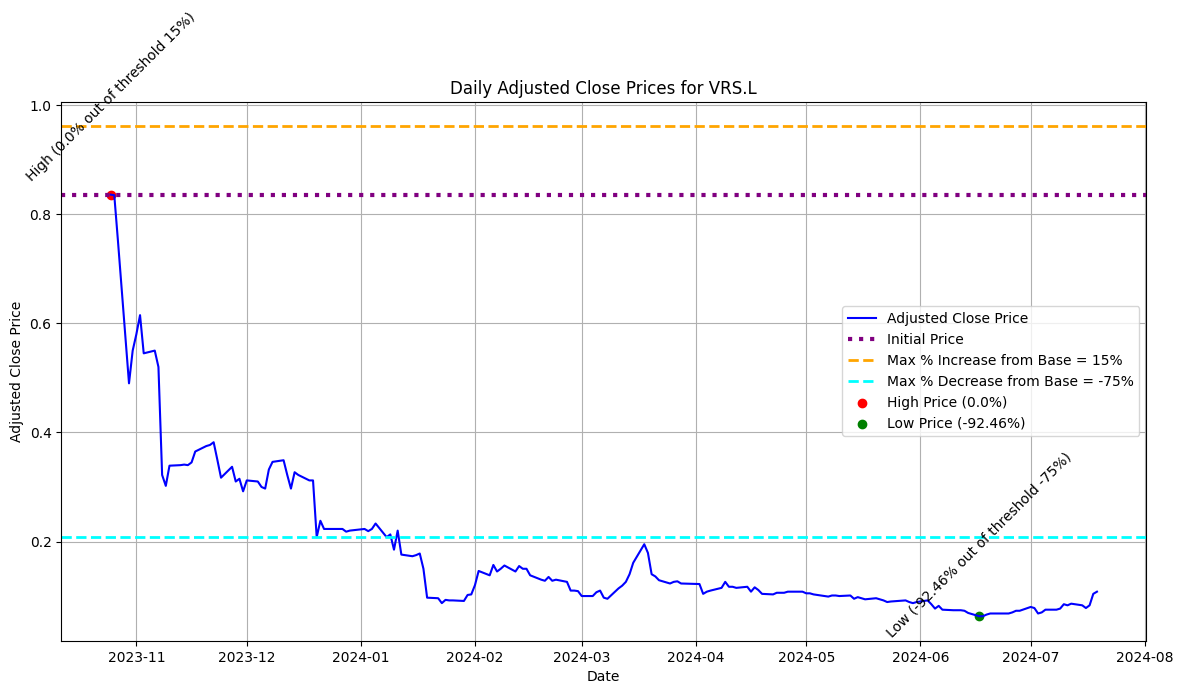

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
aim_df = pd.read_csv('aim_casino_screener_significant_decline.csv')

# Ensure that 'Max % Decrease' and other relevant columns are numeric
aim_df['Max Decrease (%)'] = pd.to_numeric(aim_df['Max Decrease (%)'], errors='coerce')
aim_df['Market Cap (GBP millions)'] = pd.to_numeric(aim_df['Market Cap (GBP millions)'], errors='coerce')
aim_df['Max Increase (%)'] = pd.to_numeric(aim_df['Max Increase (%)'], errors='coerce')
aim_df['Initial Price'] = pd.to_numeric(aim_df['Initial Price'], errors='coerce')

# Define the threshold percentages
#max_increase_percent = 35
#max_decrease_percent = -35

# Filter the DataFrame based on the given criteria
#aim_filtered = aim_df[
    #(aim_df['Market Cap (GBP millions)'] < 10) &  # Market cap less than £10 million
    #(aim_df['Max Increase (%)'] < max_increase_percent) &  # Max increase in price
    #(aim_df['Max Decrease (%)'] > max_decrease_percent)  # Max decrease in price
#].copy()

# Extract the ticker symbols
stock_symbols = aim_filtered['Unnamed: 0']

# Identify date columns based on the format 'YYYY-MM-DD 00:00:00'
date_columns = aim_filtered.columns[aim_filtered.columns.str.contains(r'^\d{4}-\d{2}-\d{2} 00:00:00$')]

# Convert date columns to proper datetime objects without the time part
formatted_dates = pd.to_datetime(date_columns, format='%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d')

# Loop through each symbol and plot the daily prices
for symbol in stock_symbols:
    try:
        # Extract the row for the current stock symbol
        stock_row = aim_filtered[aim_filtered['Unnamed: 0'] == symbol].iloc[0]

        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Date': pd.to_datetime(formatted_dates),
            'Adjusted Close': stock_row[date_columns].values
        })

        # Drop rows where 'Adjusted Close' could not be converted
        plot_data = plot_data.dropna(subset=['Adjusted Close'])

        # Check if plot_data is empty after dropping NaNs
        if plot_data.empty:
            continue

        # Plot the adjusted close prices
        plt.figure(figsize=(14, 7))
        plt.plot(plot_data['Date'], plot_data['Adjusted Close'], label='Adjusted Close Price', color='blue')

        # Add initial price line
        initial_price = stock_row['Initial Price']
        plt.axhline(y=initial_price, color='purple', linestyle=':', linewidth=3, label='Initial Price')

        # Add high and low prices
        high_price = stock_row['High Price']
        low_price = stock_row['Low Price']

        # Calculate the percentages from initial price
        high_percent = round(((high_price - initial_price) / initial_price) * 100, 2)
        low_percent = round(((low_price - initial_price) / initial_price) * 100, 2)

        # Calculate the threshold values
        max_increase_threshold = initial_price * (1 + max_increase_percent / 100)
        max_decrease_threshold = initial_price * (1 + max_decrease_percent / 100)

        # Add horizontal lines for the thresholds with labels including the percentages
        plt.axhline(y=max_increase_threshold, color='orange', linestyle='--', linewidth=2, label=f'Max % Increase from Base = {max_increase_percent}%')
        plt.axhline(y=max_decrease_threshold, color='cyan', linestyle='--', linewidth=2, label=f'Max % Decrease from Base = {max_decrease_percent}%')

        # Find the dates where the high and low prices occurred
        high_date = plot_data.loc[plot_data['Adjusted Close'] == high_price, 'Date']
        low_date = plot_data.loc[plot_data['Adjusted Close'] == low_price, 'Date']

        # High annotation with dot
        if len(high_date) > 0:
            high_date = high_date.iloc[0]
            plt.scatter(high_date, high_price, color='red', label=f'High Price ({high_percent}%)')
            plt.annotate(
                f'High ({high_percent}% out of threshold {max_increase_percent}%)',
                xy=(high_date, high_price),
                xytext=(0, 10),  # Adjust text position
                textcoords='offset points',
                ha='center',
                rotation=45
            )

        # Low annotation with dot
        if len(low_date) > 0:
            low_date = low_date.iloc[0]
            plt.scatter(low_date, low_price, color='green', label=f'Low Price ({low_percent}%)')
            plt.annotate(
                f'Low ({low_percent}% out of threshold {max_decrease_percent}%)',
                xy=(low_date, low_price),
                xytext=(0, -15),  # Adjust text position
                textcoords='offset points',
                ha='center',
                rotation=45
            )

        # Ensure all labels are included in the legend
        plt.legend(loc='best')

        # Add titles and labels
        plt.title(f"Daily Adjusted Close Prices for {symbol}")
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.grid(True)

        # Display the plot
        plt.show()

        plt.close()  # Close the plot to avoid excessive memory usage

    except Exception as e:
        print(f"Error processing {symbol}: {e}")
